In [153]:
# preamble. 
import numpy as np # basic vector/matrix math
import matplotlib.pyplot as plt # plotting and illustrations 
import seaborn as sns # advanced plotting and illustrations. 
import pandas as pd # data loading, saving, and general data manipulation. 
import scipy.stats as stats # inter alia, statistical distributions, functions and relevant objects.
import scipy.optimize as optimize 
import torch # ML/AI model's and general optimization 

# needed for this lab 
from sklearn.preprocessing import PowerTransformer
from sklearn.mixture import GaussianMixture

import torch
import math as m 
from torch.nn import Module 
import torch.nn as nn 
from torch.nn.functional import softmax 
from tqdm import tqdm 

In [154]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# STA 2453 Lab 3 Submission

This lab notebook must be completed in the appropriate time during class and invigilated by the instructor. There are  3 parts in this evaluation, you must add both this notebook, and another generated `.py` file to the PR. 

Once the PR is in place, please tag both me and the TA in it. So in the end you will have two files. 

- `STA2453-Lab-3.ipynb`
- `STA2453-Lab-3.py`

Both of these are needed for a good submission. 







---

## Case Study: The St. Louis Risk Research Project 

---

Was an observational study to assess the affects of parental
psychological disorders on child development. In the preliminary study, 69 families with 2 children were studied. The link to the dataset can be found here: 
`https://utstat.utoronto.ca/~pocucan/st4.csv`

---

This data is collected from a reading scores of 69 famlies with 2 children. 
It contains the following variables:

- `R1` Reading score of child 1

- `V1` Verbal score of child 1

- `R2` Reading score of child 2

- `V2` Verbal score of child 2

---







---

## Part 1 Power Transforms 
---

This part of the evaluation requires you to employ power transforms to transform data from asymmetric to normal. 

Load the `stlouis` dataset in, plot a histogram of the `R1` and `V1` variables, and comment on the shape of them. 

Next, fit a power transform model on the two variables, and plot histograms  of the transformed data for `R1` and `V1`. 

Compare and contrast the before/after histograms for the transformations.


In [155]:
# load the dataset st4 dataset. 
# load data
df = pd.read_csv("/content/gdrive/MyDrive/STA2453/st4.csv").iloc[:, 1:] 

In [156]:
df

,R1,V1,R2,V2
0,110.0,NaN,NaN,150.0
1,118.0,165.0,NaN,130.0
2,116.0,145.0,114.0,125.0
3,NaN,NaN,126.0,NaN
4,118.0,140.0,118.0,123.0
...,...,...,...,...
64,128.0,NaN,121.0,NaN
65,NaN,120.0,108.0,118.0
66,NaN,NaN,100.0,140.0
67,105.0,138.0,74.0,75.0


Text(0.5, 1.0, 'Histogram of verbal score for child 1')

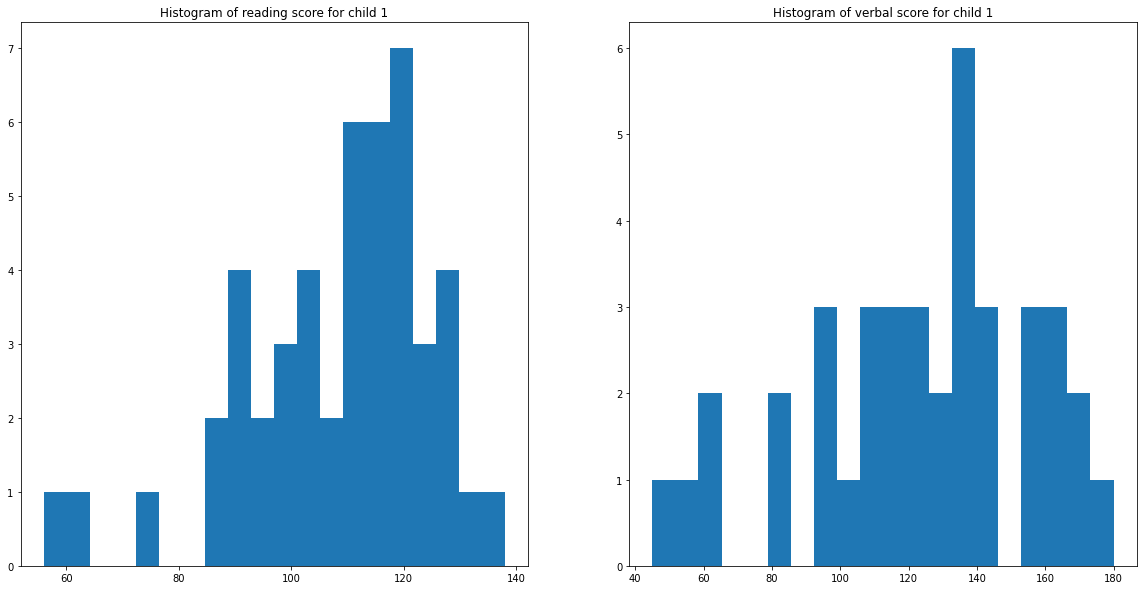

In [157]:
# plot histograms of the reading and verbal score for child 1.
from matplotlib.pyplot import figure
figure(figsize=(20, 10))
plt.tight_layout()

plt.subplot(1, 2, 1)
plt.hist(df['R1'], bins=20)
plt.title("Histogram of reading score for child 1")

plt.subplot(1, 2, 2)
plt.hist(df['V1'], bins=20)
plt.title("Histogram of verbal score for child 1")

Text(0.5, 1.0, 'Histogram of transformed verbal score for child 1')

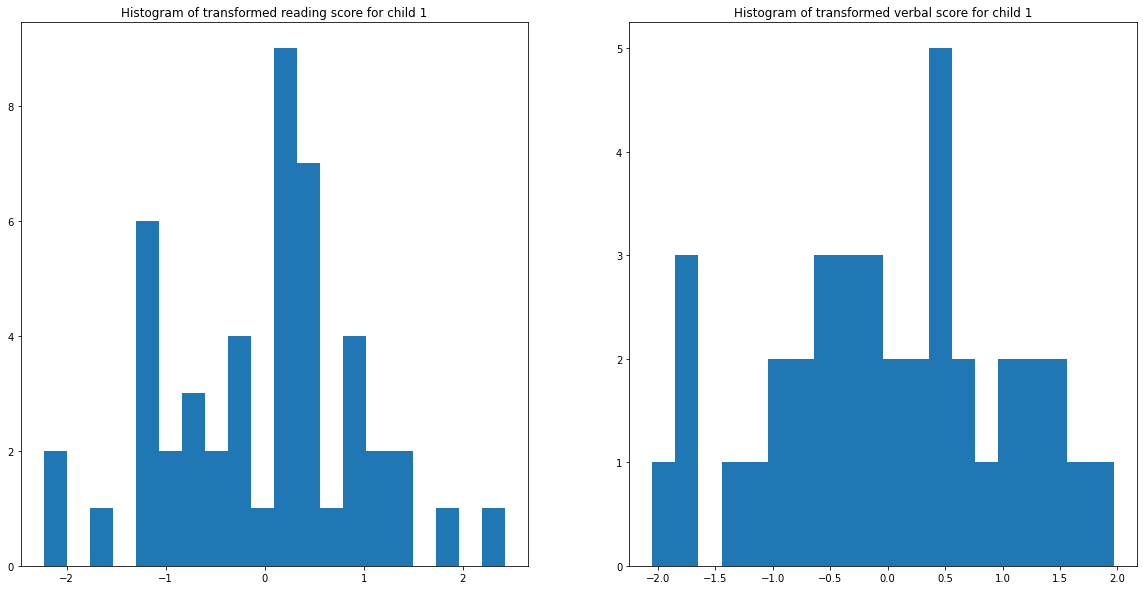

In [158]:
# declare a power transformer 
pt = PowerTransformer()  # use default method ’yeo-johnson’

# segment the relevant data for said power transformer
pt_df = df[["R1", "V1"]]

# clean the relevant data accordingly.
# remove fully missing observations
fully_na = pt_df.isna().all(axis=1)
pt_df = pt_df.loc[~fully_na, :].copy()  

# fit the power transformer onto the dataset. 
tf = pt.fit_transform(pt_df)

# transform the data, fit into dataframe. 
df_trans = pd.DataFrame(tf)
df_trans.columns = pt_df.columns

# plot histograms. 
figure(figsize=(20, 10))
plt.tight_layout()

plt.subplot(1, 2, 1)
plt.hist(df_trans['R1'], bins=20)
plt.title("Histogram of transformed reading score for child 1")

plt.subplot(1, 2, 2)
plt.hist(df_trans['V1'], bins=20)
plt.title("Histogram of transformed verbal score for child 1")

---
## Part 2 Imputation
---

Take the original data. Perform an imputation procedure using a GMM model as discussed in class. 

Find the optimal number of G via some metric, show your results. 

Plot a pairsplot with the following schematic: 
- grey points are fully complete datapoints. 
- blue points are imputed datapoints and overlayed with the original grey. 

Comment on the fits and any relationships. 


In [159]:
def density(xi: np.array, pis: np.array, mus: np.array, Ss:np.array):
    """ 
    Calculate log density of a multivariate normal density
    """
    
    p = xi.shape[0]
    leading_constant = (np.pi * 2.0) ** (- p * 0.5)
    
    xm = xi - mus
    xm = np.expand_dims(xm,axis=0)
    Ss_inv = np.linalg.inv(Ss)
    res = (xm.transpose(1,0,2) @ Ss_inv).transpose(1,0,2)
    res = np.exp( ( -0.5 * (res * xm).sum(-1)) )
   
    # result 
    res = pis * np.sqrt(np.linalg.det(Ss_inv)) * res 
    res = float(leading_constant) * res	
    
    return res 

def conditional_mean_imputation(X: np.array, pis: np.array, mus: np.array, Ss: np.array):
    """
    Calculates cmi imputation based on z, mu, sigma, and x, for partials. 
    
    Takes in a vector x (1,p)     
    """

    # get missing vector index. 
    mis = pd.DataFrame(X).isna().to_numpy() 

    for i in range(X.shape[0]):
        xi = X[i,:] 
        mi = mis[i,:] 
        # get non missing entries
        xi_d = xi[~mi]

        # get parameters
        mu_d = mus[:, ~mi]
        mu_m = mus[:, mi] 
        Ss_dd = Ss[:, ~mi][:,:, ~mi]
        Ss_md = Ss[:, mi][:,:,~mi]
        Ss_mm = Ss[:, mi][:,:,mi]

        # compute conditional means 
        dd_diff = np.expand_dims(xi_d - mu_d,-1)
        
        # leading matrix term
        lmatrix_term = Ss_md @ ( np.linalg.inv(Ss_dd))
        mu_tildes = mu_m + (lmatrix_term @ (dd_diff))[:,:,0] 

        zigs = density(xi_d, pis, mu_d, Ss_dd) 
        zigs = zigs / zigs.sum()
        zigs[0,-1] = 1.0 - zigs[0,:-1].sum()
        zigs = zigs.transpose() 
        xi_m_imputed = (mu_tildes * zigs).sum(0)
        xi[mi] = xi_m_imputed 

    return X 

In [160]:
# Segment the dataset into missing/non-missing respectively -> df_na and df_complete.

# get na mask
na_mask = df.isna().any(axis=1) 
# get imcomplete observations
df_na = df.loc[na_mask, :]

# remove fully missing observations
fully_na = df_na.isna().all(axis=1)
df_na = df_na.loc[~fully_na, :].copy() 

# get complete observations
df_complete = df.loc[~na_mask, :]

In [161]:
# Fit finite mixture models and find optimal G via choosing the smallest BIC.
optimal_G = 1
optimal_bic = float('inf')

for G in range(1,11):
  mm = GaussianMixture(n_components=G)
  mm.fit(df_complete.to_numpy())  
  bic = mm.bic(df_complete.to_numpy())
  if bic < optimal_bic:
    optimal_bic = bic
    optimal_G = G

# fit optimal GMM
mm = GaussianMixture(n_components=optimal_G)
mm.fit(df_complete.to_numpy())  

print(f"The optimal number of G is {optimal_G}.")

The optimal number of G is 10.


In [162]:
# acquire parameters of GMM
mus = mm.means_
Ss = mm.covariances_
pis = mm.weights_

# impute missing data
x_imputed_numpy = conditional_mean_imputation(np.copy(df_na.to_numpy()), pis, mus, Ss)

df_imputed = pd.DataFrame(x_imputed_numpy)    
df_imputed.columns = df_complete.columns

Text(0.5, 1.0, 'Imputed data for child 2')

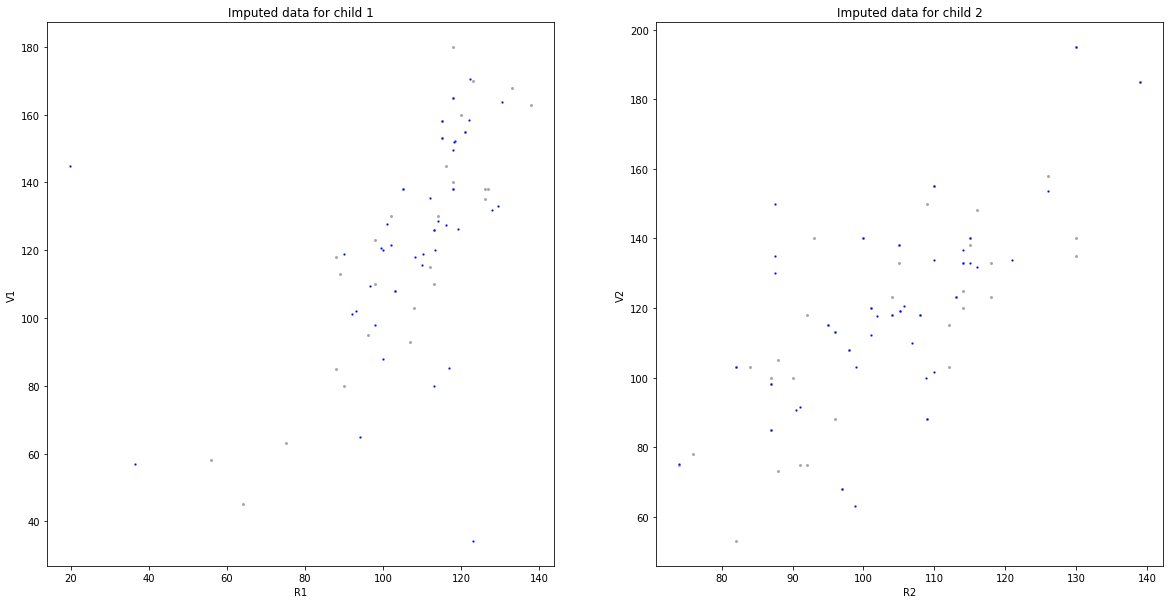

In [163]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

sns.scatterplot(x='R1', y='V1', data=df, ax=ax1, alpha=0.7, s=10, color="grey")
sns.scatterplot(x='R1', y='V1', data=df_imputed, ax=ax1, alpha=1.0, s=5, edgecolor="lightblue", color="blue")
ax1.set_title("Imputed data for child 1")

sns.scatterplot(x='R2', y='V2', data=df, ax=ax2, alpha=0.7, s=10, color="grey")
sns.scatterplot(x='R2', y='V2', data=df_imputed, ax=ax2, alpha=1.0, s=5, edgecolor="lightblue", color="blue")
ax2.set_title("Imputed data for child 2")

<ipython-input-142-0f7de06c56a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complete["df"] = "complete"


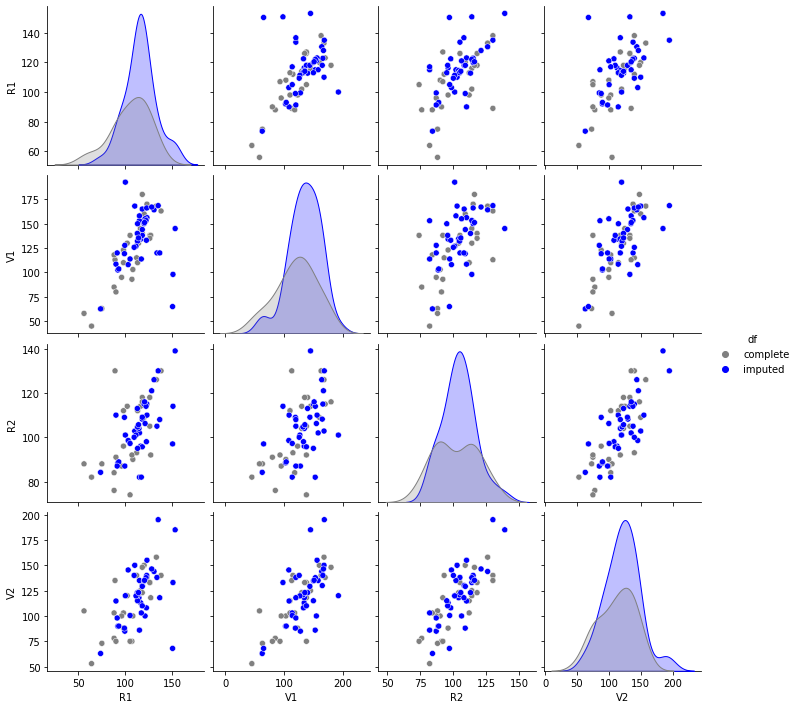

In [142]:
df_complete["df"] = "complete"
df_imputed["df"] = "imputed"
df_full = pd.concat([df_complete, df_imputed], ignore_index=True)
sns.pairplot(df_full, hue="df", palette={"complete": "grey", "imputed": "blue"})

---
## Part 3 Transformation and Imputation 
---

Take the original data. Perform an imputation procedure using a mixture model `AND` a transformation procedure together. 

To achieve a level 3 you must incorporate the transformation coherently, and, fit a mixture model after for imputation purposes. Here, the transformation, and fitting of the mixture model is done `SEPARATELY`. Ensure that during the imputation step you are working in the Gaussian space, and then transform it appropriately to desired domain of the original data. You are free to use any transformation scheme you like, Power transforms, Manly, etc. 

To achieve a level 4 you must adequatly incorporate a transformation `DIRECTLY` within the density of the mixture model component definition, and, fit it appropriately within an estimation step. It is reasonable to assume that if your component-wise distribution is already Gaussian, than your transformation method will still work, just won't be doing much.  

Find the optimal number of G via some metric, show your results. 

Plot a pairsplot with the following schematic: 
- grey points are fully complete datapoints. 
- red points are imputed datapoints and overlayed with the original grey. 

Comment on the impuation and any relationships within the data, compare and contrast the results of the red points vs the blue points from Part 2. 


## Method 1. Incorporate the transformation coherently, and, fit a mixture model after for imputation purposes.

In [164]:
# Transform the original data using method ’yeo-johnson’.
pt = PowerTransformer()
tf = pt.fit_transform(df)

df_trans = pd.DataFrame(tf)
df_trans.columns = df.columns

In [165]:
# Segment the transformed dataset into missing/non-missing respectively 
# -> df_trans_na and df_trans_complete.

# get na mask
na_mask = df_trans.isna().any(axis=1) 
# get transformed imcomplete observations
df_trans_na = df_trans.loc[na_mask, :]

# remove fully missing observations
fully_na = df_trans_na.isna().all(axis=1)
df_trans_na = df_trans_na.loc[~fully_na, :].copy() 

# get transformed complete observations
df_trans_complete = df_trans.loc[~na_mask, :]

In [166]:
# Fit finite mixture models and find optimal G via choosing the smallest BIC.
optimal_G = 1
optimal_bic = float('inf')

for G in range(1,11):
  mm = GaussianMixture(n_components=G)
  mm.fit(df_trans_complete.to_numpy())  
  bic = mm.bic(df_trans_complete.to_numpy())
  if bic < optimal_bic:
    optimal_bic = bic
    optimal_G = G

mm = GaussianMixture(n_components=optimal_G)
mm.fit(df_trans_complete.to_numpy())  

print(f"The optimal number of G is {optimal_G}.")

The optimal number of G is 9.


In [167]:
# acquire parameters of GMM
mus = mm.means_
Ss = mm.covariances_
pis = mm.weights_

# impute missing data
x_imputed_numpy = conditional_mean_imputation(np.copy(df_trans_na.to_numpy()), pis, mus, Ss)
x_imputed_numpy = pt.inverse_transform(x_imputed_numpy)  # inverse transform back to the original scale

df_trans_imputed = pd.DataFrame(x_imputed_numpy)    
df_trans_imputed.columns = df_complete.columns

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Imputed data for child 2')

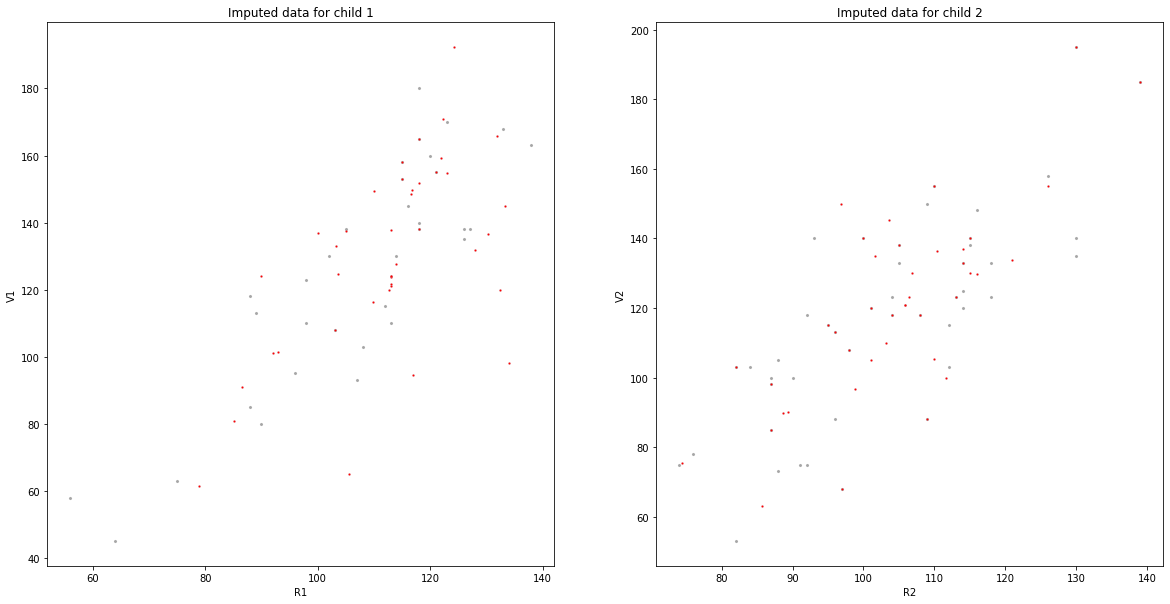

In [168]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

sns.scatterplot(x='R1', y='V1', data=df, ax=ax1, alpha=0.7, s=10, color="grey")
sns.scatterplot(x='R1', y='V1', data=df_trans_imputed, ax=ax1, alpha=1.0, s=5, edgecolor="lightblue", color="red")
ax1.set_title("Imputed data for child 1")

sns.scatterplot(x='R2', y='V2', data=df, ax=ax2, alpha=0.7, s=10, color="grey")
sns.scatterplot(x='R2', y='V2', data=df_trans_imputed, ax=ax2, alpha=1.0, s=5, edgecolor="lightblue", color="red")
ax2.set_title("Imputed data for child 2")

<ipython-input-176-6cfae246f1b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complete["df"] = "complete"


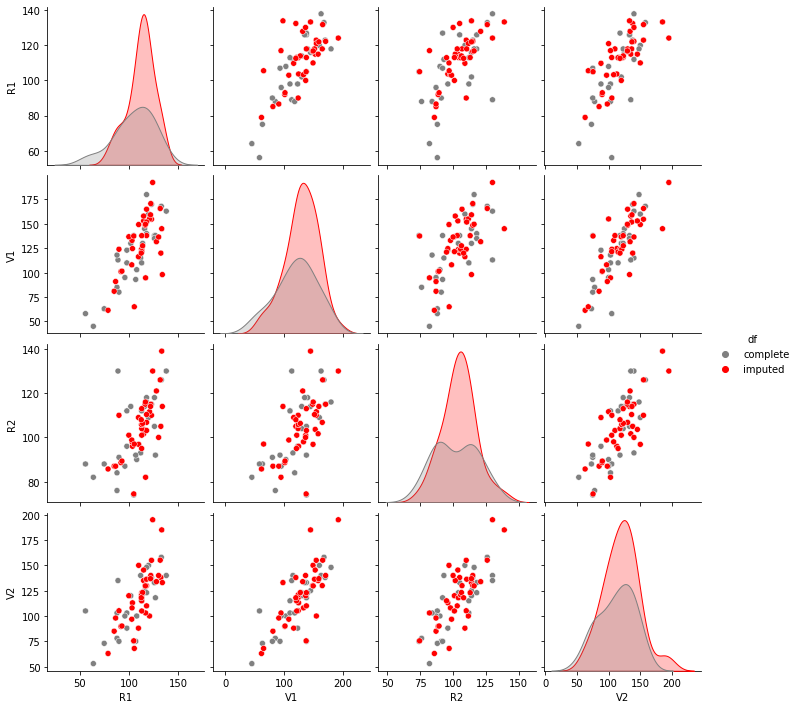

In [176]:
df_complete["df"] = "complete"
df_trans_imputed["df"] = "imputed"
df_trans_full = pd.concat([df_complete, df_trans_imputed], ignore_index=True)
sns.pairplot(df_trans_full, hue="df", palette={"complete": "grey", "imputed": "red"})

In [169]:
# based on this approach, the tails are captured much better, data is imputed clearly. 

## Method 2. Incorporate a transformation DIRECTLY within the density of the mixture model.

In [170]:
class ClusterWeightedImputationModel(nn.Module):
    """
    Class for Finite mixtures of Linear models with Yeo-Johnson transformation and imputation.
    """

    def __init__(self, G:int, data: torch.Tensor):
        """
            Constructor class for finite mixtures of linear models.
        """

        if not isinstance(data, torch.Tensor):
            raise Exception("data is not of torch.Tensor type")

        super(ClusterWeightedImputationModel, self).__init__()

        # define constants.
        self.n = data.shape[0]
        self.G = G if G > 0 else exec("raise Exception('G has to be valid')")

        # define data
        self.X = data[:,1:]

        # Perform Yeo-Johnson transformation on X
        self.pt = PowerTransformer()
        tf = self.pt.fit_transform(self.X)
        tf_df = pd.DataFrame(tf) 
        self.X = torch.Tensor(tf_df.to_numpy())

        self.X = torch.concat( (self.X, torch.ones(self.n,1)), axis=1)
        self.y = data[:,0]

        # first column is y, the rest are covariates.
        self.p = self.X.shape[1]
        self.x = self.X[:,0] # model covariates

        # define actual parameters.
        self.betas = torch.rand(G,self.p)
        self.sigmas = torch.rand(G,1).abs()
        self.w = torch.rand(G,1) # define weights.

        # define covariate parameters.
        self.xsigmas = torch.rand(G,1).abs()
        self.xmus = torch.rand(G,1)

        # set gradients.
        self.w.requires_grad = True;
        self.betas.requires_grad = True;
        self.sigmas.requires_grad = True;
        self.xsigmas.requires_grad = True;
        self.xmus.requires_grad = True;
        self.leading_constants = - 0.5 * torch.Tensor([2.0 * torch.pi]).log()

    def compute_weights(self):
        """
            get mixing proportions.
        """
        return softmax(self.w[:,0], dim=0)


    def log_density(self, X, y) -> torch.Tensor:
        """
            Takes in a covariate dataset X, and sample y,
            computes an (n x G) matrix of log densities.
        """

        # calculate log density.
        ldens = torch.zeros(self.n, self.G)

        # loop through the groups.
        for g in range(0,self.G):

            # compute linear model.
            y_hats = (self.betas[g] * self.X).sum(-1)

            # compute exponential terms.
            exp_terms = - 0.5 * ((y_hats - y) / self.sigmas[g]).pow(2)
            ldens[:,g] = exp_terms + self.leading_constants
            ldens[:,g] += - self.sigmas[g].log()

            # compute covariate terms.
            ldens[:,g] += - self.xsigmas[g].log() + self.leading_constants
            ldens[:,g] += - 0.5 * ((self.x - self.xmus[g])/ self.xsigmas[g]).pow(2)

            # add Jacobian of the transformation
            ldens[:,g] += (self.pt.lambdas_[g] - 1) * y.log() / self.n

        return ldens


    def objective_fn(self, X, y):
        """
            Objective function to minimize on,
            takes in an (n x d + 1) matrix with the response variable
            in the first column
        """

        # compute log densities.
        dens = self.log_density(X, y).exp()

        # get weights.
        W = self.compute_weights()

        return -((dens * W).sum(-1).log()).sum()

    def train(self, lr=1e-3, max_iterations=1000):
        """
            train using some gradient descent algorithm
        """

        # define optimizer
        optimizer = torch.optim.Adam([self.w,
                                      self.betas,
                                      self.sigmas,
                                      self.xsigmas,
                                      self.xmus], lr=lr)
        # track loss
        loss = np.zeros(max_iterations)
        tq_obj = tqdm(range(max_iterations), desc="Model Training")

        for it in tq_obj:
            optimizer.zero_grad()
            cost = self.objective_fn(self.X, self.y)
            cost.backward() # compute gradient.
            optimizer.step()

            loss[it] = cost.data.cpu().numpy()

            # log the loss.
            if it % 100 == 0:
                tqdm.write(f"Loss: {loss[it]}  λ: {optimizer.param_groups[0].get('lr')}")

    def fit(self, X, betas):
        """
           Take input covariate X and fits using the coefficients betas.
           Returns an (n x G) matrix, one for every component
        """

        ys = torch.zeros(X.shape[0], betas.shape[0])

        for g in range(self.G):
            ys[:,g] = (betas[g] * X).sum(-1)

        return ys

    def BIC(self):
        """
            Calculates the Bayesian Information Criterion for model performance comparisons.
        """

        # calculate number of parameters.
        rho = self.betas.numel() + self.sigmas.numel() + self.w.numel()
        bic = self.objective_fn(self.X, self.y) * (-2.0) - rho * m.log(self.y.shape[0])
        return float(bic.detach())


    def plot(self, col):
        """
            col: reference column
        """

        plot_df = torch.concat((self.y.unsqueeze(-1), self.X), dim=1)
        plot_df = pd.DataFrame(plot_df.detach().numpy())
        plot_df = plot_df[[0,col]]

        sns.scatterplot(x=plot_df[col], y=plot_df[0], color="grey",s=2.0)

        y_fits = self.fit(self.X, self.betas)

        for g in range(self.G):
            plot_df['y_fit'] = y_fits[:,g].detach().numpy()
            sns.scatterplot(x=plot_df[col], y=plot_df['y_fit'], color="red", s=2.0)

        plt.savefig("cwm-fit.png")
        plt.clf()

    def plot_colors(self, col, labs):
        """
            col: reference column.
            labs: integer np.array
        """

        color_plt = sns.color_palette("dark", int(np.max(labs)) + 1)

        plot_df = torch.concat((self.y.unsqueeze(-1), self.X), dim=1)
        plot_df = pd.DataFrame(plot_df.detach().numpy())
        plot_df = plot_df[[0,col]]
        plot_df['color'] = pd.Series(labs).apply(lambda x: color_plt[x])

        sns.scatterplot(x=plot_df[col], y=plot_df[0], color=plot_df['color'],s=2.0)

        plt.savefig("cwm-fit-color.png")
        plt.clf()

    def Estep(self, X, y):
        """
            Computes the expectation step using parameters for X ,y
        """

        with torch.no_grad():
            dens = self.log_density(X, y).exp()

            W = self.compute_weights()
            dens = dens * W

            d_sum = dens.sum(-1).unsqueeze(-1)
            dens = dens / d_sum

            #dens[:,-1] = 1.0 - dens[:,:-1].sum(-1)

        return dens

    def MAP(self, X, y):
        """
            Computes labels using the maximum a posterior
        """

        dens = self.Estep(X,y)
        labs = dens.argmax(-1)
        labs = labs.detach().numpy()
        labs = labs.astype(int)
        return labs

    def impute(self, df_na):
        """
        Imputate the missing values df by estimated GMM parameters on complete data.
        """
        # acquire estimated parameters of GMM
        mus = self.xmus.detach().numpy()
        Ss = self.xsigmas.detach().numpy()
        pis = self.w.detach().numpy()

        # impute missing data
        tf_na = self.pt.fit_transform(self.X)
        tf_na_df = pd.DataFrame(tf_na) 
        x_imputed_numpy = conditional_mean_imputation(np.copy(tf_na_df.to_numpy()), pis, mus, Ss)
        x_imputed_numpy = self.pt.inverse_transform(x_imputed_numpy)  # inverse transform back to the original scale

        df_imputed = pd.DataFrame(x_imputed_numpy)    
        df_imputed.columns = df_complete.columns

        return df_imputed

In [171]:
data_s = torch.Tensor(df_complete.to_numpy())
data_s = (data_s - data_s.mean())/data_s.std()  

# Define model with complete data. 
G = 3
cwm = ClusterWeightedImputationModel(G=G, data=data_s)
# run a training 
cwm.train(lr=1e-2, max_iterations=1000)

Model Training:   7%|▋         | 69/1000 [00:00<00:02, 347.96it/s]

Loss: nan  λ: 0.01


Model Training:  14%|█▍        | 139/1000 [00:00<00:02, 331.05it/s]

Loss: nan  λ: 0.01


Model Training:  24%|██▍       | 239/1000 [00:00<00:02, 296.25it/s]

Loss: nan  λ: 0.01


Model Training:  34%|███▍      | 338/1000 [00:01<00:02, 305.58it/s]

Loss: nan  λ: 0.01


Model Training:  44%|████▍     | 441/1000 [00:01<00:01, 321.43it/s]

Loss: nan  λ: 0.01


Model Training:  54%|█████▍    | 543/1000 [00:01<00:01, 320.51it/s]

Loss: nan  λ: 0.01


Model Training:  65%|██████▌   | 650/1000 [00:02<00:01, 325.00it/s]

Loss: nan  λ: 0.01


Model Training:  75%|███████▌  | 751/1000 [00:02<00:00, 319.96it/s]

Loss: nan  λ: 0.01


Model Training:  85%|████████▍ | 849/1000 [00:02<00:00, 291.30it/s]

Loss: nan  λ: 0.01


Model Training:  95%|█████████▍| 948/1000 [00:03<00:00, 308.70it/s]

Loss: nan  λ: 0.01


Model Training: 100%|██████████| 1000/1000 [00:03<00:00, 307.50it/s]


Text(0.5, 1.0, 'Imputed data for child 2')

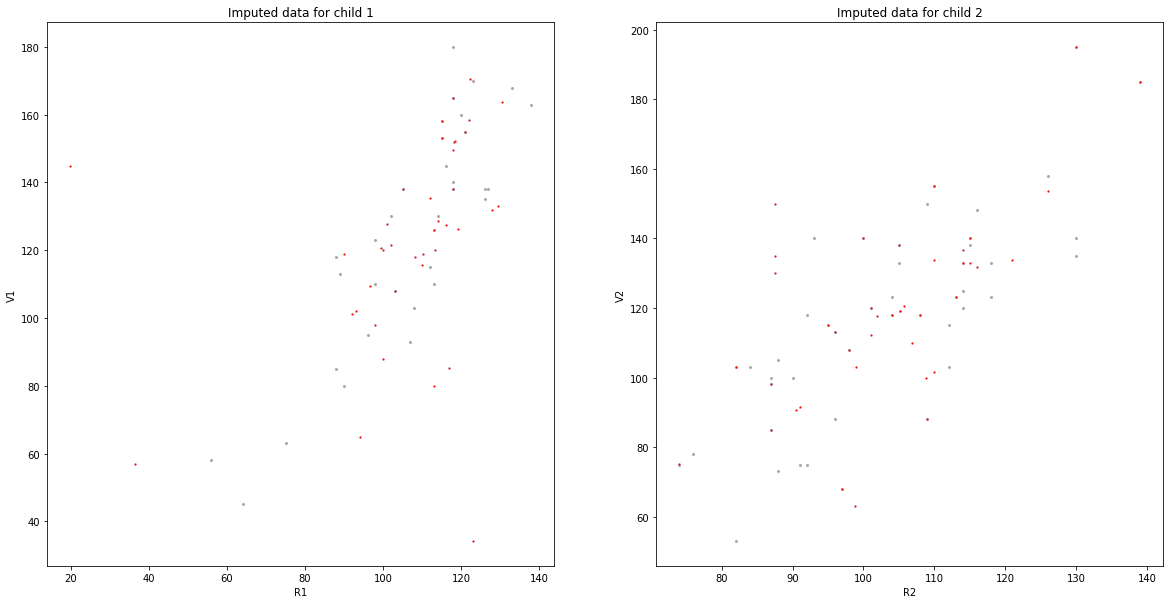

In [175]:
# Impute missing values.
df_imputed = cwm.impute(df_na)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(x='R1', y='V1', data=df, ax=ax1, alpha=0.7, s=10, color="grey")
sns.scatterplot(x='R1', y='V1', data=df_imputed, ax=ax1, alpha=1.0, s=5, edgecolor="lightblue", color="red")
ax1.set_title("Imputed data for child 1")

sns.scatterplot(x='R2', y='V2', data=df, ax=ax2, alpha=0.7, s=10, color="grey")
sns.scatterplot(x='R2', y='V2', data=df_imputed, ax=ax2, alpha=1.0, s=5, edgecolor="lightblue", color="red")
ax2.set_title("Imputed data for child 2")

<ipython-input-177-3c0727a75177>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complete["df"] = "complete"


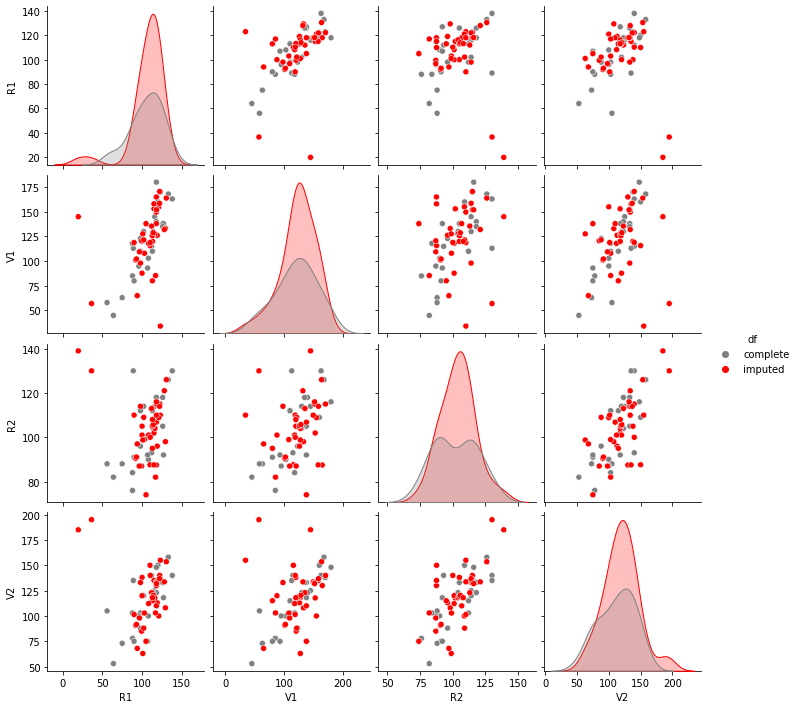

In [177]:
df_complete["df"] = "complete"
df_imputed["df"] = "imputed"
df_full = pd.concat([df_complete, df_imputed], ignore_index=True)
sns.pairplot(df_full, hue="df", palette={"complete": "grey", "imputed": "red"})